# Timbre Encoder
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the data to train our timbre encoder.

There are two models here, the first is a vowel classifier, that takes in an MFCC and outputs a vowel, and the second is a VAE that takes in an MFCC, reduces its dimensionality, and attempts to reconstruct the provided MFCC.

## Global variables/Imports
Run these cells before running either of the following sections.

In [34]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [36]:
n_mels = 128
n_mfcc = 20

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

For the classifier, MFCC are normalized by row to `[-1, 1]`, as the classifer can learn it better.
For the VAE, MFCC are normalized by row to `[0, 1]`, to allow the VAE to output it.

In [37]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training - not used here
# data_label_pairs, _ = create_data_label_pairs(n_pitches)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, plot=False) 
                              for waveform in all_wav_data ])
all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

**Comment one of these lines**

In [38]:
#Normalize each mfcc (i.e. rows of the all_mfcc array) to [-1,1] - USE FOR THE CLASSIFER (TimbreEncoder)
# all_mfcc = normalize_rows(all_mfcc, NormMode.REAL_TO_NEG_ONE_ONE)
#Normalize each mfcc (i.e. rows of the all_mfcc array) to [0,1] - USE FOR THE VAE (TimbreVAE)
all_mfcc = normalize_rows(all_mfcc, NormMode.REAL_TO_ZERO_ONE)

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

Generate `data` and `labels` from `all_mfcc` and using `nd_ref_idx`.

In [39]:
n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

# vowel_labels: (576) (n_wavs)
all_vowel_labels, _, _ = map(np.array, map(list, zip(*
                         [ nd_ref_idx(idx) 
                           for idx in range(len(flat_data_ref_list)) ])))

# Returns a flat 2d idx, given a wavfile index and a window index
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
# labels: (33408) (n_wavs * n_windows)
data = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                  for wav_file_idx in range(n_files) 
                  for window_idx in range(n_windows) ])
labels = np.array([ all_vowel_labels[wav_file_idx]
                    for wav_file_idx in range(n_files)
                    for window_idx in range(n_windows) ])

In [40]:
# For testing purposes - verify that the mfcc have been arranged in order of
# wav_idx, win_idx, mel_feature_idx
for wav_idx in range(n_files):
    for win_idx in range(n_windows):
        for m in range(n_mfcc_dummy):
            assert data[flat_data_idx(wav_idx, win_idx)][m] == \
                   all_mfcc[wav_idx][m][win_idx]
# Verify that the labels are arranged in order of wav_idx, win_idx
for wav_idx in range(n_files):
    for win_idx in range(n_windows):
        assert labels[flat_data_idx(wav_idx, win_idx)] == \
               all_vowel_labels[wav_idx]

Split Data into `train` and `test`, and convert to Torch tensors of the correct types. Run **only one of these cells.**

First method (**not-recommended**, simple): Random sampling to train and test

In [ ]:
# X_train, Y_train: (25056, 20) (25056) 
# X_val, Y_val:     (8352, 20) (8352)
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
# Used as index, so it is long
Y_train = Y_train.long(); Y_val = Y_val.long()

Second method **(recommended)**: 1 person from each wav will be the test data

In [41]:
# X_train, Y_train: (22272, 20) (22272,) 
# X_val, Y_val:     (11136, 20) (11136,)
X_train = []; X_val = []; Y_train = []; Y_val = []
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
# Used as index, so it is long
Y_train = Y_train.long(); Y_val = Y_val.long()

### Timbre-Encoder - MFCC -> Vowel
This takes MFCC (and mel-spectrograms in future?), and tries to identify the vowel spoken.

**Results:**
```
| epochs | n_mfcc | n_hid | n_timb | Val acc |
|   5000 |     20 |    12 |      4 | 0.77898 |
```

In [ ]:
n_hid = 12; n_timb = 4; lr = 0.2; n_epochs = 5000;

# Training model 
model = TimbreEncoder(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb, n_vowels=n_vowels)
# Define loss 
loss_fn = F.cross_entropy

In [ ]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

In [ ]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreEncoder_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Loading the saved model, and using the model for prediction (whole dataset) example

In [ ]:
model = TimbreEncoder(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb, n_vowels=n_vowels)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)

data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.long(); 
# data_tensor = data_tensor.to(device); label_tensor = label_tensor.to(device)

correct = 0; wrong = 0;
corrects = np.zeros(n_vowels); wrongs = np.zeros(n_vowels)
predictions = np.zeros((n_vowels, n_vowels));
for vowel_idx in range(n_vowels):
    for pitch_idx in range(n_pitches):
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vowel_idx, pitch_idx, pid_idx)
            for win_idx in range(n_windows):
                data_idx = flat_data_idx(wav_idx, win_idx)
                label = (label_tensor[data_idx]).item()
                pred = (torch.argmax(model(data_tensor[data_idx]))).item()
                
                predictions[vowel_idx][pred] = predictions[vowel_idx][pred] + 1
                if label == pred:
                    correct = correct + 1
                    corrects[vowel_idx] = corrects[vowel_idx] + 1
                else:
                    wrong = wrong + 1
                    wrongs[vowel_idx] = wrongs[vowel_idx] + 1
                    
print("Total Accuracy: {}"
      .format(correct / (wrong + correct)))
for vowel_idx in range(n_vowels):
    print("Vowel: {}. Accuracy: {}. Most common pred: {}"
          .format(label_to_vowel[vowel_idx],
                  corrects[vowel_idx] / (wrongs[vowel_idx] + corrects[vowel_idx]),
                  label_to_vowel[np.argmax(predictions[vowel_idx])]))


### Timbre-VAE - MFCC -> MFCC
This takes MFCC, reduces dimensionality to a `n_timb` latent space, and attempts to recreate the MFCC.

In [42]:
n_hid = 10; n_timb = 4; lr = 1e-3; n_epochs = 10000; batch_size=22272

# Training model 
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [43]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


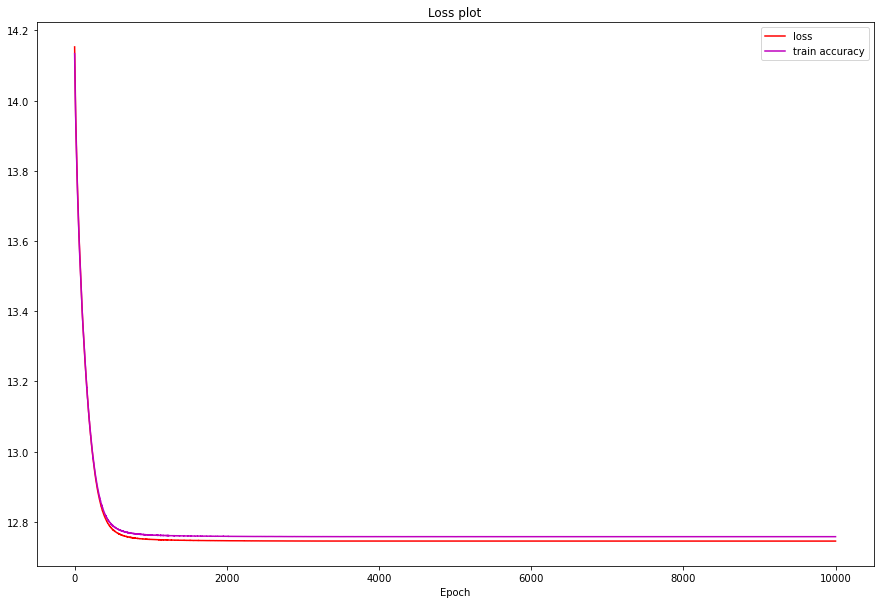

Training Loss before/after: 14.152862899604886, 12.745376762302442
Validation Loss before/after: 14.133682426364942, 12.757947198275861
Final loss: (12.745376762302442, 12.757944392061782)
Time taken: 97.92482924461365


In [44]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
X_val = X_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                        epochs=n_epochs, print_graph = True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [45]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreVAE_lr{}_epochs{}_nmfcc{}_nhid{}_ntimb{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
en1.weight 	 torch.Size([10, 20])
en1.bias 	 torch.Size([10])
en_mu.weight 	 torch.Size([4, 10])
en_mu.bias 	 torch.Size([4])
en_std.weight 	 torch.Size([4, 10])
en_std.bias 	 torch.Size([4])
de1.weight 	 torch.Size([10, 4])
de1.bias 	 torch.Size([10])
de2.weight 	 torch.Size([20, 10])
de2.bias 	 torch.Size([20])
Model saved at model_data\TimbreVAE_lr0.001_epochs10000_nmfcc20_nhid10_ntimb4_(12.745376762302442, 12.757944392061782).pt


Loading the saved model, and using the model for prediction example

In [46]:
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)
model.load_state_dict(torch.load(model_path))
model.eval()

data_tensor = torch.tensor(data)
data_tensor = data_tensor.float();

wav_idx = flat_ref_idx(5, 5, 1)
data_idx = flat_data_idx(wav_idx, 30)
label = data_tensor[data_idx]
pred = model(data_tensor[data_idx])[0]
latent = model.get_z(data_tensor[data_idx])

print(label)
print(pred)
print(latent)

tensor([0.0000, 0.9751, 0.5035, 0.5754, 0.5136, 0.4108, 0.4069, 0.5212, 0.5884,
        0.4402, 0.4514, 0.4929, 0.4635, 0.4682, 0.5167, 0.4709, 0.5345, 0.5320,
        0.4620, 0.4920])
tensor([0.0221, 0.9477, 0.4320, 0.5652, 0.5092, 0.4936, 0.4293, 0.4917, 0.5016,
        0.4374, 0.4713, 0.4868, 0.4783, 0.4741, 0.4910, 0.4817, 0.4983, 0.4924,
        0.4880, 0.4746], grad_fn=<SigmoidBackward>)
tensor([-0.7843, -1.1944,  0.6204, -0.7380], grad_fn=<AddBackward0>)


## Experiment: Choosing `n_hid`, `n_timb`

From running this, we find the results:
Best `n_hid`: 10, Best `n_timb`: 4

In [23]:
# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

n_hid_candidates = [6, 8, 10, 12, 14, 16, 18]
n_timb_candidates = [4, 6, 8, 10, 12, 14, 16]
lr = 1e-3; n_epochs = 2500; batch_size=22272
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

losses = []
for hid_idx in range(len(n_hid_candidates)):
    for timb_idx in range(len(n_timb_candidates)):
        if (hid_idx < timb_idx): continue
        n_hid = n_hid_candidates[hid_idx]
        n_timb = n_timb_candidates[timb_idx]
        
        # Training model 
        model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

        X_train = X_train.to(device)
        X_val = X_val.to(device)
        model.to(device) 
        # opt = optim.SGD(model.parameters(), lr=lr)
        opt = optim.Adam(model.parameters(), lr=lr)

        # Fit the model
        tic = time.time()
        loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                                epochs=n_epochs, print_graph=False, desc="n_hid: {}, n_timb: {}".format(n_hid, n_timb))
        toc = time.time()
        print('n_hid: {}, n_timb: {}, Final val loss: {}, Time taken: {}'.format(n_hid, n_timb, val_loss, toc - tic))
        model_path = os.path.join("model_data", "TimbreVAE_n_hid_n_timb_experiment_{}_{}_{}.pt"
                                  .format(n_hid, n_timb, val_loss))
        torch.save(model.state_dict(), model_path)
        print("Model saved at {}".format(model_path)) 
        losses.append(val_loss)


n_hid: 6, n_timb: 4, Final val loss: 12.756245229436063, Time taken: 24.036638021469116
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_6_4_12.756245229436063.pt



n_hid: 8, n_timb: 4, Final val loss: 12.756556719198993, Time taken: 23.402870178222656
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_8_4_12.756556719198993.pt



n_hid: 8, n_timb: 6, Final val loss: 12.757583793552442, Time taken: 24.187214136123657
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_8_6_12.757583793552442.pt



n_hid: 10, n_timb: 4, Final val loss: 12.755354256465518, Time taken: 23.62875461578369
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_10_4_12.755354256465518.pt



n_hid: 10, n_timb: 6, Final val loss: 12.756701239224139, Time taken: 23.57104468345642
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_10_6_12.756701239224139.pt



n_hid: 10, n_timb: 8, Final val loss: 12.75628732264727, Time taken: 23.87569832801819
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_10_8_12.75628732264727.pt



n_hid: 12, n_timb: 4, Final val loss: 12.75652725395115, Time taken: 23.377437353134155
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_4_12.75652725395115.pt



n_hid: 12, n_timb: 6, Final val loss: 12.756516029094827, Time taken: 24.132755041122437
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_6_12.756516029094827.pt



n_hid: 12, n_timb: 8, Final val loss: 12.757957020025144, Time taken: 21.46918272972107
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_8_12.757957020025144.pt



n_hid: 12, n_timb: 10, Final val loss: 12.757127783764368, Time taken: 24.31379532814026
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_10_12.757127783764368.pt



n_hid: 14, n_timb: 4, Final val loss: 12.75653426948635, Time taken: 23.120083808898926
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_4_12.75653426948635.pt



n_hid: 14, n_timb: 6, Final val loss: 12.75579904139727, Time taken: 23.299814462661743
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_6_12.75579904139727.pt



n_hid: 14, n_timb: 8, Final val loss: 12.757596421515805, Time taken: 24.524491548538208
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_8_12.757596421515805.pt



n_hid: 14, n_timb: 10, Final val loss: 12.756250841864224, Time taken: 24.066789388656616
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_10_12.756250841864224.pt



n_hid: 14, n_timb: 12, Final val loss: 12.757847577676007, Time taken: 23.379464149475098
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_12_12.757847577676007.pt



n_hid: 16, n_timb: 4, Final val loss: 12.75629153196839, Time taken: 23.141919136047363
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_4_12.75629153196839.pt



n_hid: 16, n_timb: 6, Final val loss: 12.75677841011135, Time taken: 23.408835649490356
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_6_12.75677841011135.pt



n_hid: 16, n_timb: 8, Final val loss: 12.757703057650861, Time taken: 23.205310583114624
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_8_12.757703057650861.pt



n_hid: 16, n_timb: 10, Final val loss: 12.756217167295258, Time taken: 18.973145723342896
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_10_12.756217167295258.pt



n_hid: 16, n_timb: 12, Final val loss: 12.756746138649426, Time taken: 18.91083335876465
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_12_12.756746138649426.pt



n_hid: 16, n_timb: 14, Final val loss: 12.757397180316092, Time taken: 19.097800970077515
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_14_12.757397180316092.pt



n_hid: 18, n_timb: 4, Final val loss: 12.756252244971265, Time taken: 18.403200149536133
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_4_12.756252244971265.pt



n_hid: 18, n_timb: 6, Final val loss: 12.755765366828305, Time taken: 20.536202669143677
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_6_12.755765366828305.pt



n_hid: 18, n_timb: 8, Final val loss: 12.756218570402298, Time taken: 18.79640245437622
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_8_12.756218570402298.pt



n_hid: 18, n_timb: 10, Final val loss: 12.757287737966953, Time taken: 19.083486557006836
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_10_12.757287737966953.pt



n_hid: 18, n_timb: 12, Final val loss: 12.757718491828305, Time taken: 19.04806160926819
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_12_12.757718491828305.pt



n_hid: 18, n_timb: 14, Final val loss: 12.75823904454023, Time taken: 19.794686317443848
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_14_12.75823904454023.pt



n_hid: 18, n_timb: 16, Final val loss: 12.756389749461206, Time taken: 18.548084497451782
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_16_12.756389749461206.pt


In [39]:
indices = [ [n_hid_candidates[hid_idx], n_timb_candidates[timb_idx]] 
            for hid_idx in range(len(n_hid_candidates))
            for timb_idx in range(len(n_timb_candidates)) if (hid_idx >= timb_idx) ]
best_hid, best_timb = indices[np.argmin(np.array(losses))]
print("Best n_hid: {}, Best n_timb: {}".format(best_hid, best_timb))
print(np.array(list(zip(losses, indices))))

Best n_hid: 10, Best n_timb: 4
[[12.756245229436063 list([6, 4])]
 [12.756556719198993 list([8, 4])]
 [12.757583793552442 list([8, 6])]
 [12.755354256465518 list([10, 4])]
 [12.756701239224139 list([10, 6])]
 [12.75628732264727 list([10, 8])]
 [12.75652725395115 list([12, 4])]
 [12.756516029094827 list([12, 6])]
 [12.757957020025144 list([12, 8])]
 [12.757127783764368 list([12, 10])]
 [12.75653426948635 list([14, 4])]
 [12.75579904139727 list([14, 6])]
 [12.757596421515805 list([14, 8])]
 [12.756250841864224 list([14, 10])]
 [12.757847577676007 list([14, 12])]
 [12.75629153196839 list([16, 4])]
 [12.75677841011135 list([16, 6])]
 [12.757703057650861 list([16, 8])]
 [12.756217167295258 list([16, 10])]
 [12.756746138649426 list([16, 12])]
 [12.757397180316092 list([16, 14])]
 [12.756252244971265 list([18, 4])]
 [12.755765366828305 list([18, 6])]
 [12.756218570402298 list([18, 8])]
 [12.757287737966953 list([18, 10])]
 [12.757718491828305 list([18, 12])]
 [12.75823904454023 list([18, 14])